In [2]:
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

from shapely.geometry import Polygon

In [3]:
import torch
import torch.nn as nn

from torchvision.models import resnet18, resnet50
from torch.utils.data import Dataset, DataLoader

from torch.utils.tensorboard import SummaryWriter

/home/tokyo-jazz/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/tokyo-jazz/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
df = pd.read_csv("Train/markup.csv", header=None, encoding='utf-16')
df

,0,1,2,3,4,5,6,7,8,9,10
0,fc272e4092ccb147a31e66bc1d10fbfb.png,3601514743345,538,248,1590,225,1597,663,532,676,1010101111000110101100110111001011001101000110...
1,8cde8cb1b54bca37c9347baf74157d22.png,7000001062307,372,433,360,1289,124,1293,147,431,1010001101010011100011010100111000110101100110...
2,70a9be0887eae17eabd70c8e607f963f.png,2250001407126,408,230,1224,229,1224,688,414,683,1010010011011000101001110100111000110101100110...
3,a029e49dff95a15d2cd396d8f62220c8.png,10101427156,335,149,1005,155,1005,438,335,447,1010001101001100100011010011001000110100110010...
4,82ff01909b6d215170dfc26c7be43074.png,2400745402226,469,237,1388,260,1392,712,464,696,1010100011000110101001110010001010001101110010...
...,...,...,...,...,...,...,...,...,...,...,...
8194,c532771808e76e333ba9e959853886f3.png,4823077510083,86,54,622,53,622,202,87,202,1010110111001101101111010001101001000100100010...
8195,186338ad8f3ff17b6082c023f24563f0.png,4823077505386,109,44,664,55,668,206,107,192,1010110111001101101111010001101001000100100010...
8196,5bac8f6c9bd5e99f92eb396442974c4e.png,4823077505492,121,27,704,13,704,168,120,187,1010110111001101101111010001101001000100100010...
8197,6247db3e424148a859ebf2180f1dcb6f.png,2010000019696,158,81,165,518,62,521,55,82,1010001101001100101001110100111000110101001110...


In [5]:
def display_im(idx):
    im = cv2.imread("Train/Images/" + df[0][idx])
    plt.plot(df[2][idx], df[3][idx], marker='v', color='red')
    plt.plot(df[4][idx], df[5][idx], marker='v', color='green')
    plt.plot(df[6][idx], df[7][idx], marker='v', color='yellow')
    plt.plot(df[8][idx], df[9][idx], marker='v', color='blue')
    plt.imshow(im)
    

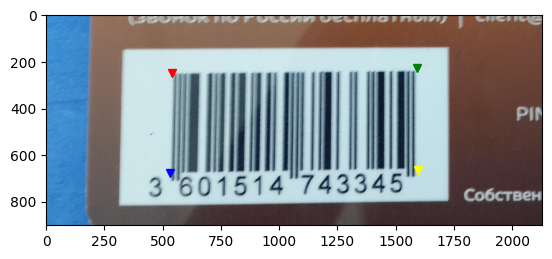

In [6]:
display_im(0)

In [7]:
class ToSquare(nn.Module):
    def forward(self, img, x1, y1, x2, y2, x3, y3, x4, y4):
        h, w, _ = img.shape
        return (np.pad(
                img, 
                (
                    (max(0, (w - h) // 2), max(0, (w - h + 1) // 2)),
                    (max(0, (h - w) // 2), max(0, (h - w + 1) // 2)),
                    (0, 0)
                ),
                constant_values=127.5
            ), 
            x1 + max(0, (h - w) // 2), 
            y1 + max(0, (w - h) // 2), 
            x2 + max(0, (h - w) // 2), 
            y2 + max(0, (w - h) // 2), 
            x3 + max(0, (h - w) // 2), 
            y3 + max(0, (w - h) // 2), 
            x4 + max(0, (h - w) // 2), 
            y4 + max(0, (w - h) // 2)
        )

class ToSquareSize(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size
        
    def forward(self, img, x1, y1, x2, y2, x3, y3, x4, y4):
        img, x1, y1, x2, y2, x3, y3, x4, y4 = ToSquare()(img, x1, y1, x2, y2, x3, y3, x4, y4)
        cur_size = img.shape[0]
        img = cv2.resize(img, (self.size, self.size))
        x1 = (x1 * self.size / cur_size)
        y1 = (y1 * self.size / cur_size)
        x2 = (x2 * self.size / cur_size)
        y2 = (y2 * self.size / cur_size)
        x3 = (x3 * self.size / cur_size)
        y3 = (y3 * self.size / cur_size)
        x4 = (x4 * self.size / cur_size)
        y4 = (y4 * self.size / cur_size)
        return img, x1, y1, x2, y2, x3, y3, x4, y4

In [8]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet50()
        self.resnet.fc = nn.Linear(2048, 8)

    def forward(self, x):
        return self.resnet(x)

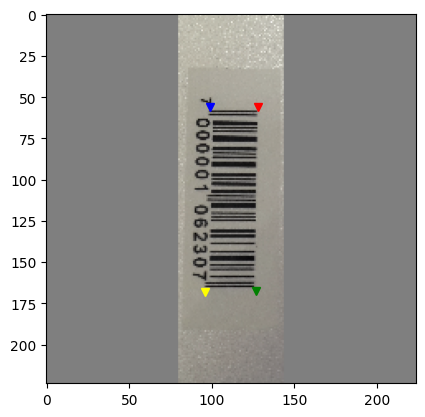

In [9]:
idx = 1
im = cv2.imread("Train/Images/" + df[0][idx])
im, x1, y1, x2, y2, x3, y3, x4, y4 = ToSquareSize(224)(
    im,
    df[2][idx], df[3][idx],
    df[4][idx], df[5][idx],
    df[6][idx], df[7][idx],
    df[8][idx], df[9][idx]
)

plt.plot(x1, y1, marker='v', color='red')
plt.plot(x2, y2, marker='v', color='green')
plt.plot(x3, y3, marker='v', color='yellow')
plt.plot(x4, y4, marker='v', color='blue')
plt.imshow(im)    

In [12]:
train_df, test_df = train_test_split(df, test_size=0.1)

In [10]:
class MyDataset(Dataset):
    def __init__(self, df, path='./Train/Images/'):
        super().__init__()
        self.path = path
        self.df = df        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        im = cv2.imread(os.path.join(self.path + row[0]))
        im, x1, y1, x2, y2, x3, y3, x4, y4 = ToSquareSize(224)(
            im,
            row[2], row[3],
            row[4], row[5],
            row[6], row[7],
            row[8], row[9]
        )
        im = (im - 127.5) / 255
        return torch.tensor(im).permute(2, 0, 1), torch.tensor([x1, y1, x2, y2, x3, y3, x4, y4])

In [14]:
train_dataset = MyDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True, num_workers=8)

val_dataset = MyDataset(test_df)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True, num_workers=8)

In [11]:
model = MyModel()
assert torch.cuda.is_available()
device = torch.device('cuda')
model.to(device)

MyModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [16]:
class MyLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, inputs, targets):
        ious = []
        for idx in range(len(inputs)):
            pred_poly = Polygon((
                (inputs[idx][0], inputs[idx][1]),
                (inputs[idx][2], inputs[idx][3]),
                (inputs[idx][4], inputs[idx][5]),
                (inputs[idx][6], inputs[idx][7])
            ))
            target_poly = Polygon((
                (targets[idx][0], targets[idx][1]),
                (targets[idx][2], targets[idx][3]),
                (targets[idx][4], targets[idx][5]),
                (targets[idx][6], targets[idx][7])
            ))
            try:
                ious.append(pred_poly.intersection(target_poly).area / pred_poly.union(target_poly).area)
            except:
                ious.append(0)
        return torch.tensor(ious)

In [17]:
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [ ]:
tb = SummaryWriter()

In [20]:
def run_validation(val_loader: DataLoader, model: nn.Module, n_steps=None):
    model.eval()
    n_good = 0
    n_all = 0
    wrapper = lambda x: x
    if n_steps is None:
        n_steps = len(val_loader)
        wrapper = tqdm
    
    
    ls = []
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(wrapper(val_loader)):
            if batch == n_steps:
                break
            logits = model(X.to(torch.float32).to(device))
            ls.append(loss_fn(logits, y.to(device)).item())
            ious = MyLoss()(logits.to('cpu'), y.to('cpu')) 
            n_good += sum([1 if x > 0.5 else 0 for x in ious])
            n_all += len(ious)
    
    print("mse: ", np.mean(ls))
    return n_good / n_all


def train_epoch(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, optim, loss_fn):
    for batch, (X, y) in enumerate(tqdm(train_loader)):
        model.train()
        logits = model(X.to(torch.float32).to(device))
        loss = loss_fn(logits, y.to(torch.float32).to(device))
        
        if batch % 100 == 0:
            tb.add_scalar("losses/train_loss", loss, global_step=epoch*len(train_loader)+batch)
            ious = MyLoss()(logits, y) 
            tb.add_scalar("losses/train_acc", sum([1 if x > 0.5 else 0 for x in ious])/len(ious), global_step=epoch*len(train_loader)+batch)
            tb.add_scalar("losses/train_iou", torch.mean(ious), global_step=epoch*len(train_loader)+batch)
        
        optim.zero_grad()
        loss.backward()
        optim.step()


In [ ]:
for epoch in range(30):
    print(f'Epoch {epoch}:')
    train_epoch(train_loader, val_loader, model, optim, loss_fn)
    accuracy = run_validation(val_loader, model)
    print(f'accuracy: {accuracy}')
    torch.save(model, f"resnet50-epoch{epoch}.ckpt")

Epoch 7:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:10<00:00,  4.82it/s]


mse:  197.88390334276886
accuracy: 0.9105392156862745
Epoch 8:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.48it/s]


mse:  211.6950894160813
accuracy: 0.9399509803921569
Epoch 9:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.38it/s]


mse:  145.1169834217342
accuracy: 0.9522058823529411
Epoch 10:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.27it/s]


mse:  154.6647179979198
accuracy: 0.9411764705882353
Epoch 11:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:10<00:00,  4.87it/s]


mse:  96.62433637907033
accuracy: 0.9779411764705882
Epoch 12:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.62it/s]


mse:  146.81904840159712
accuracy: 0.9620098039215687
Epoch 13:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:10<00:00,  4.64it/s]


mse:  187.442320454652
accuracy: 0.9497549019607843
Epoch 14:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:12<00:00,  4.23it/s]


mse:  93.49386868120058
accuracy: 0.9816176470588235
Epoch 15:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.42it/s]


mse:  75.55769280211055
accuracy: 0.9828431372549019
Epoch 16:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:12<00:00,  4.07it/s]


mse:  107.52979732095977
accuracy: 0.9767156862745098
Epoch 17:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.30it/s]


mse:  89.19046943434037
accuracy: 0.9840686274509803
Epoch 18:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.34it/s]


mse:  119.8943905211338
accuracy: 0.9595588235294118
Epoch 19:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.31it/s]


mse:  64.44467113825534
accuracy: 0.9852941176470589
Epoch 20:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.38it/s]


mse:  72.48151796735142
accuracy: 0.9840686274509803
Epoch 21:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.42it/s]


mse:  66.74544991710778
accuracy: 0.9877450980392157
Epoch 22:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:12<00:00,  4.10it/s]


mse:  83.75265771617718
accuracy: 0.9877450980392157
Epoch 23:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.31it/s]


mse:  70.93334906616958
accuracy: 0.9865196078431373
Epoch 24:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.43it/s]


mse:  98.31550923451405
accuracy: 0.9816176470588235
Epoch 25:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.36it/s]


mse:  69.07292305424522
accuracy: 0.9901960784313726
Epoch 26:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.39it/s]


mse:  51.820844699908214
accuracy: 0.9926470588235294
Epoch 27:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.58it/s]


mse:  66.64408418889185
accuracy: 0.991421568627451
Epoch 28:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.47it/s]


mse:  77.61440822221519
accuracy: 0.9865196078431373
Epoch 29:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:12<00:00,  4.09it/s]


mse:  55.162783790666055
accuracy: 0.9901960784313726


# Test

In [13]:
test_df = pd.read_csv("answer.csv", header=None, encoding='utf-16')
test_dataset = MyDataset(test_df, path="./Test/Images/")
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8)

In [14]:
model = torch.load('resnet50-epoch29.ckpt').to('cuda')

In [15]:
preds = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        preds.extend(model(X.to(torch.float32).cuda()).detach().cpu().numpy())
preds = np.array(preds)

100%|█████████████████████████████████| 7/7 [00:02<00:00,  3.45it/s]


In [16]:
for idx in range(len(test_df)):
    fnm = test_df.iloc[idx][0]
    im = cv2.imread(os.path.join("./Test/Images", fnm))
    h, w, _ = im.shape
    
    preds[idx] *= max(h, w) / 224
    
    dx = max(0, (h - w) // 2)
    dy = max(0, (w - h) // 2)
    
    preds[idx][0] -= dx
    preds[idx][2] -= dx
    preds[idx][4] -= dx
    preds[idx][6] -= dx
    
    preds[idx][1] -= dy
    preds[idx][3] -= dy
    preds[idx][5] -= dy
    preds[idx][7] -= dy
    
    test_df.iat[idx, 1] = ''
    test_df.iat[idx, 10] = ''
    
    for i in range(8):
        test_df.iat[idx, 2 + i] = round(preds[idx][i])

In [17]:
for col in range(2, 2 + 8):
    test_df[col] = test_df[col].astype(int)
test_df

,0,1,2,3,4,5,6,7,8,9,10
0,5825c9d1deb6572b6dba440d5c6482bf.png,,532,449,1658,409,1706,1360,582,1404,
1,f9bf5d96a0cf5d64aac4eb5806554224.png,,661,419,1739,494,1708,1270,632,1197,
2,a154b624c06072da1a01c97ebc3894c1.png,,557,494,1542,283,1645,746,657,964,
3,749003091876fc58be69db54bbaae8f1.png,,509,282,1541,203,1593,630,560,713,
4,560ca4ac1260313eb5979140c4f9ef31.png,,588,259,1614,283,1625,736,597,716,
...,...,...,...,...,...,...,...,...,...,...,...
95,bf547f52301ee51df5faf1a6dc678740.png,,823,1974,868,301,2125,355,2072,2045,
96,d7d7c5f9109aa31aff407eeab054bfc7.png,,469,2183,482,638,1281,647,1271,2205,
97,d6230eb6dc78728c09024eb674c427ef.png,,279,1448,238,484,680,484,721,1450,
98,f534d421c7e36d6133a5e9031a7e2dd5.png,,253,1897,254,532,683,532,684,1900,


In [18]:
test_df.to_csv("answer.csv", header=None, index=False, encoding='utf-16')